In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import torch
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
# torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import wandb

from nca_model import SimpleNCA
from utils import nca_out_to_vids, tonp, save_model, load_latest_model, nca_cmap, pad_to
from data import (
    MNISTPatternGenerator,
    MNISTPatternPool,
    generate_radial_circles_pattern,
    generate_canonical_mnist_digits,
)

In [3]:
device = "cuda"
num_classes = 10
channs = 16
bs = 16
S = 32
lr = 0.0008
pool_size = 64
pool_replacement = 0.7

In [4]:
nca = SimpleNCA(channs).to(device)

In [5]:
inp = torch.rand(5, channs, S, S).to(device)
out = nca(inp, steps=50)
len(out), out[0].shape

(51, torch.Size([5, 16, 32, 32]))

,,,,

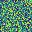
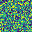
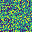
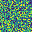
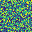

In [6]:
nca_out_to_vids(out)

,,,,,,,,,

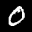
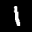
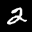
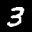
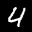
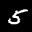
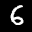
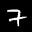
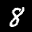
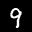

In [7]:
canonical_mnist_digits = generate_canonical_mnist_digits()
canonical_mnist_digits = pad_to(canonical_mnist_digits, S)

mpy.show_images(canonical_mnist_digits, width=100)

In [8]:
pool = MNISTPatternPool(
    is_train=True, channs=channs, size=S, pool_size=pool_size, pattern=canonical_mnist_digits,
    replacement=pool_replacement
)
sample = pool.sample(bs=bs)
inp = sample.batch["inp"][:, 0]
out = sample.batch["out"]

,,,,,,,,,,,,,,,

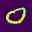
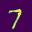
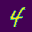
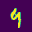
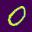
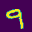
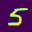
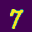
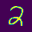
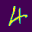
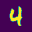
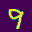
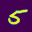
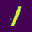
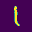
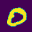

In [9]:
mpy.show_images(inp, cmap="viridis", width=100)

,,,,,,,,,,,,,,,

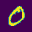
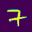
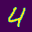
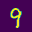
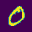
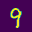
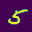
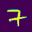
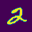
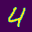
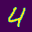
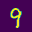
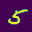
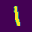
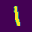
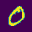

In [10]:
mpy.show_images(out, cmap="viridis", width=100)

In [11]:
nca = SimpleNCA(channs).to(device)

In [12]:
train_gen = MNISTPatternPool(
    is_train=True, channs=channs, size=S, pool_size=pool_size, pattern=canonical_mnist_digits,
    replacement=pool_replacement
)

optim = torch.optim.Adam(nca.parameters(), lr=lr)
history = []

In [13]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./train.ipynb"

experiment_name = "nca-80-canon-alive-mask"

run = wandb.init(
    project="nca-classifier",
    name=experiment_name,
    save_code=True,
)
_ = run.log_code(
    "./",
    include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./train.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ichko to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loss: 0.0157215912:   0%|          | 0/50000 [00:00<?, ?it/s]

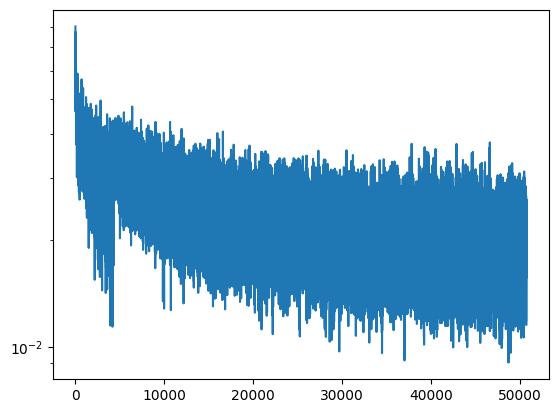

,,,,,,,
,,,,,,,

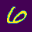
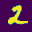
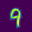
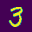
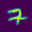
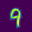
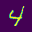
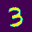
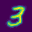
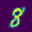
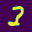
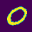
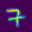
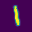
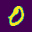
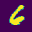


KeyboardInterrupt



In [26]:
pbar = tqdm(range(50_000))

for i in pbar:
    sample = train_gen.sample(bs)
    inp, out_gt = sample.batch["inp"], sample.batch["out"]
    out_gt = out_gt.to(device)

    steps = np.random.randint(30, 80)
    out_pred = nca(inp.to(device), steps=steps)
    last_step = out_pred[-1]
    last_frame = last_step[:, 0]

    losses = F.mse_loss(last_frame, out_gt, reduction="none")
    losses = losses.reshape(bs, -1).mean(axis=1)
    loss = losses.mean()

    train_gen.update(sample, last_step, losses)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss:.10f}")
    run.log({"loss": loss.item()})

    history.append(loss.item())

    if i % 150 == 0:
        clear_output()
        display(pbar.container)
        
        plt.plot(history)
        plt.yscale("log")
        plt.show()
        
        save_model(nca, experiment_name, i)
        
        with torch.inference_mode():
            out_pred = nca(inp.to(device), steps=50)
            nca_out_to_vids(out_pred, columns=8)

            run.log({"train_example": [
                wandb.Video(v, fps=20) for v in nca_cmap(out_pred)
            ]})

In [25]:
save_path = save_model(nca, experiment_name, i)
wandb.save(save_path)
save_path

'.checkpoints/nca-80-canon-alive-mask/nca-46453-[2025-05-05-11-33-13].pkl'

In [27]:
run.finish()

loss,▅█▅▅▆▇▆▄▃▄▄▃▆▄▂▄▄▃▄▄▂▄▅▄▄▃▃▃▃▃▃▁▃▂▃▂▃▂▃▃
loss,0.01793


## Explore outputs

In [13]:
nca_loaded = torch.load(".checkpoints/nca-80-canon-alive-mask/nca-46453-[2025-05-05-11-33-13].pkl")
nca_loaded = nca_loaded.to(device)

In [14]:
test_gen = MNISTPatternGenerator(
    is_train=False,
    channs=channs,
    bs=1,
    pattern=canonical_mnist_digits,
    loop_forever=False,
    shuffle=False,
)

In [15]:
res = []
with torch.inference_mode():
    for batch in tqdm(test_gen):
        out_pred = nca_loaded(batch["inp"].to(device), steps=50)

        rollout = tonp(out_pred[:, 0, 0])

        last_step = out_pred[-1]
        last_frame = last_step[:, 0]
        loss = F.mse_loss(last_frame, batch["out"].to(device))

        res.append({
#             "rollout": rollout,
            "label": tonp(batch["label"][0]).item(),
            "loss": loss.item(),
        })

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
import pandas as pd

In [120]:
df = pd.DataFrame(res).reset_index()
low_loss = df.sort_values("loss").iloc[:10]
high_loss = df.sort_values("loss").iloc[-10:]
rand_loss = df.sort_values("loss").sample(10)

In [121]:
grouped = []
for i in range(num_classes):
    item = df.groupby("label").get_group(i).sort_values("loss").iloc[800]
    grouped.append(item.to_dict())

In [122]:
ids = [int(g["index"]) for g in grouped]

In [123]:
rollouts = []
with torch.inference_mode():
    for idx in tqdm(ids):
        item = test_gen.ds[idx]
        inp = item["inp"].unsqueeze(0).to(device)
        out_pred = nca_loaded(inp, steps=80)
        rollout = tonp(out_pred[:, 0, 0])
        rollouts.append(rollout)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,,,,,,

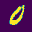
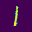
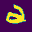
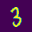
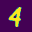
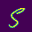
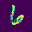
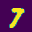
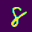
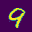

,,,,,,,,,

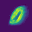
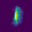
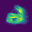
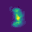
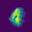
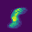
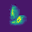
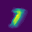
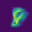
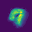

,,,,,,,,,

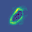
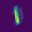
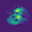
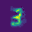
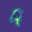
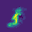
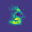
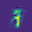
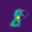
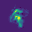

,,,,,,,,,

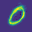
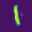
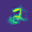
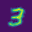
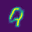
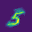
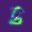
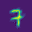
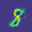
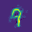

,,,,,,,,,

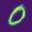
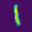
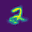
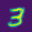
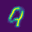
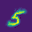
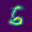
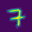
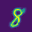
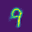

,,,,,,,,,

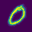
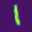
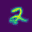
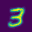
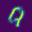
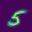
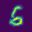
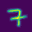
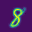
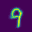

In [124]:
for i in [0, 10, 20, 30, 40, -1]:
    mpy.show_images([r[i] for r in rollouts], cmap="viridis", width=80)

,,,,,,,,,

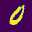
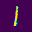
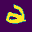
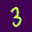
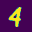
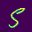
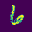
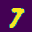
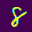
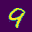

In [58]:
mpy.show_videos([
    mpy.to_rgb(r, cmap="viridis", vmin=0, vmax=1) for r in rollouts],
    width=120,
    codec="gif",
    fps=25
)

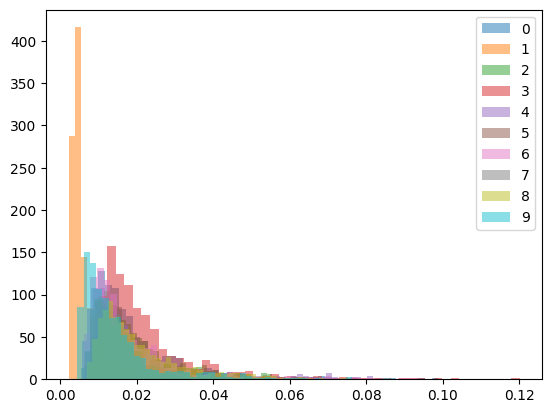

In [180]:
for c in range(num_classes):
    losses = df[df["label"] == c]["loss"]
    plt.hist(losses, bins=50, alpha=0.5, label=c)
plt.legend()

In [187]:
frames = []
for i in tqdm(range(num_classes)):
    vs = df.groupby("label").get_group(i).sort_values("loss")
#     print(len(vs))
    item = vs.iloc[[0, 250, 500, 800, -5]]
    it = {k: list(v.values()) for k, v in item.to_dict().items()}

    last_frames = []
    with torch.inference_mode():
        for idx in it["index"]:
            item = test_gen.ds[idx]
            inp = item["inp"].unsqueeze(0).to(device)
            out_pred = nca_loaded(inp, steps=100)
            last_frame = tonp(out_pred[-1, 0, 0])
            first_frame = tonp(out_pred[0, 0, 0])

#             last_frames.append(first_frame)
            last_frames.append(last_frame)

    frames.append(last_frames)

  0%|          | 0/10 [00:00<?, ?it/s]

,,,,

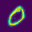
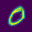
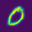
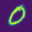
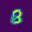

,,,,

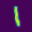
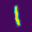
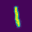
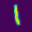
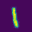

,,,,

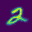
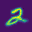
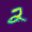
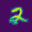
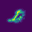

,,,,

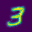
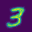
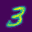
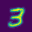
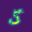

,,,,

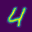
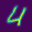
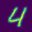
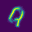
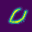

,,,,

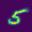
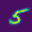
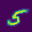
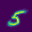
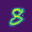

,,,,

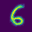
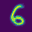
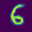
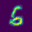
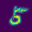

,,,,

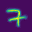
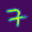
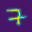
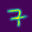
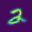

,,,,

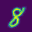
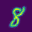
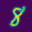
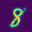
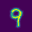

,,,,

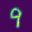
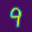
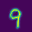
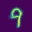
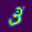

In [188]:
for f in frames:
    mpy.show_images(f, cmap="viridis", width=80)

## CLF

In [189]:
train_gen = MNISTPatternGenerator(
    is_train=True,
    channs=channs,
    bs=1,
    pattern=canonical_mnist_digits,
    loop_forever=False,
    shuffle=False,
)

In [192]:
rollout.shape

(501, 32, 32)

In [ ]:
res = []
with torch.inference_mode():
    for batch in tqdm(train_gen):
        out_pred = nca_loaded(batch["inp"].to(device), steps=50)

        rollout = tonp(out_pred[:, 0, 0])
        first_frame = rollout[0]
        last_frame = rollout[-1]

        last_step = out_pred[-1]
        last_frame = last_step[:, 0]
        loss = F.mse_loss(last_frame, batch["out"].to(device))

        res.append({
            "fist_frame": first_frame,
            "last_frame": last_frame,
            "label": tonp(batch["label"][0]).item(),
            "loss": loss.item(),
        })

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
df = 